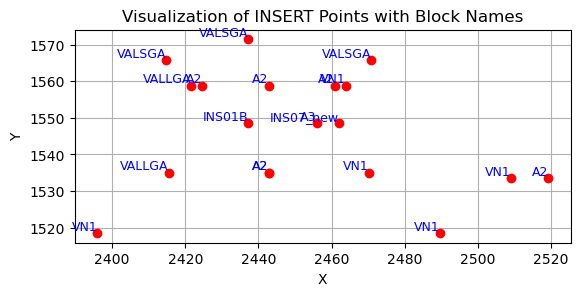

In [1]:
import ezdxf
import matplotlib.pyplot as plt

def visualize_insert_points_with_block_names(file_path):
    try:
        # 读取 DXF 文件
        doc = ezdxf.readfile(file_path)
        modelspace = doc.modelspace()

        # 创建绘图窗口
        fig, ax = plt.subplots()

        # 遍历模型空间中的所有实体
        for entity in modelspace:
            if entity.dxftype() == "INSERT":
                # 获取插入点坐标和块名称
                insert_point = entity.dxf.insert
                block_name = entity.dxf.name
                
                # 在图上绘制插入点
                ax.plot(insert_point.x, insert_point.y, 'ro')  # 红色圆点表示插入点
                ax.text(insert_point.x, insert_point.y, block_name, fontsize=9, color="blue", 
                        verticalalignment="bottom", horizontalalignment="right")

        # 设置绘图属性
        ax.set_aspect('equal')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Visualization of INSERT Points with Block Names')
        plt.grid(True)

        # 显示绘图
        plt.show()

    except Exception as e:
        print(f"无法读取或可视化 DXF 文件: {e}")

# 替换为你的 DXF 文件路径
file_path = "./block/Drawing1.dxf"  # 请替换为实际的 DXF 文件路径
visualize_insert_points_with_block_names(file_path)


点： (2612.036629654868, 1756.116098450572, 0.0) 名称： mis057 放大倍数： 24.0 24.0 旋转角度： 0
Index 1: D=5.00
Index 2: D=27.57
Index 3: D=4.85
Index 4: D=0.44


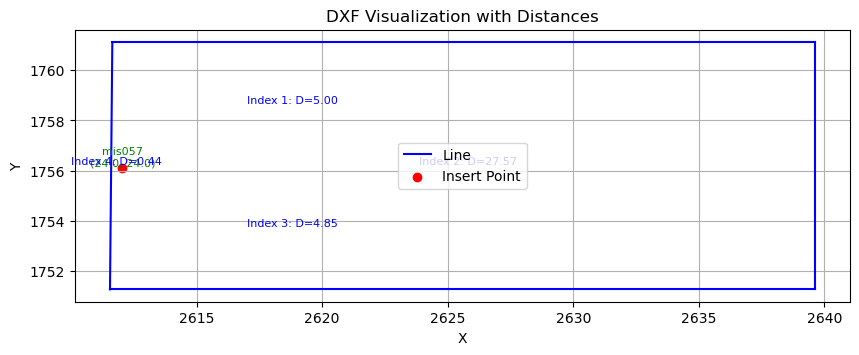

In [10]:
import ezdxf
import matplotlib.pyplot as plt
import numpy as np
import json
# 计算点到线段的最短距离
def point_to_line_distance(point, line_start, line_end):
    """
    计算点到线段的最短距离。
    :param point: 点的坐标 (x, y)
    :param line_start: 线段起点坐标 (x, y)
    :param line_end: 线段终点坐标 (x, y)
    :return: 最短距离
    """
    px, py = point.x, point.y
    x1, y1 = line_start.x, line_start.y
    x2, y2 = line_end.x, line_end.y

    # 向量计算
    line_vec = np.array([x2 - x1, y2 - y1])
    point_vec = np.array([px - x1, py - y1])
    line_len = np.dot(line_vec, line_vec)
    if line_len == 0:
        # 起点和终点重合，返回点到线段起点的距离
        return np.linalg.norm(point_vec)

    # 投影计算
    t = np.dot(point_vec, line_vec) / line_len
    t = max(0, min(1, t))  # 限制 t 在 [0, 1] 之间
    projection = np.array([x1, y1]) + t * line_vec
    return np.linalg.norm(np.array([px, py]) - projection)

# 主函数
def plot_dxf_with_distances(file_path):
    # 打开 DXF 文件
    doc = ezdxf.readfile(file_path)
    msp = doc.modelspace()

    # 用于存储线段和插入点
    lines = []
    insert_points = []

    # 遍历模型空间中的实体
    for entity in msp:
        if entity.dxftype() == "LINE":
            # 提取线段起点和终点
            start = entity.dxf.start
            end = entity.dxf.end
            lines.append((start, end))
        elif entity.dxftype() == "INSERT":
            # 提取块插入点、名称、缩放倍数和旋转角度
            insert_point = entity.dxf.insert
            block_name = entity.dxf.name
            xscale = entity.dxf.xscale
            yscale = entity.dxf.yscale
            rotation = entity.dxf.rotation  # 提取旋转角度
        
            print("点：", insert_point, "名称：", block_name, "放大倍数：", xscale, yscale, "旋转角度：", rotation)
            
            # 将信息添加到insert_points列表
            insert_points.append((insert_point, block_name, xscale, yscale, rotation))

    # 创建图形
    plt.figure(figsize=(10, 8))

    # 绘制线段
    for start, end in lines:
        x_values = [start.x, end.x]
        y_values = [start.y, end.y]
        plt.plot(x_values, y_values, 'b-', label="Line" if "Line" not in plt.gca().get_legend_handles_labels()[1] else "")

    # 绘制插入点及其信息
    if insert_points:
        for insert_point, block_name, xscale, yscale, rotation in insert_points:
            plt.scatter(insert_point.x, insert_point.y, color='red', label="Insert Point" if "Insert Point" not in plt.gca().get_legend_handles_labels()[1] else "")
            # 添加文字标签，显示块名称和缩放倍数
            label_text = f"{block_name}\n({xscale:.1f}, {yscale:.1f})"
            plt.text(insert_point.x, insert_point.y, label_text, color='green', fontsize=8, ha='center', va='bottom')
            distance_list = []
            # 计算点到每条线段的距离
            for index, (start, end) in enumerate(lines):
                distance = point_to_line_distance(insert_point, start, end)
                distance_label = f"Index {index+1}: D={distance:.2f}"  # 加上索引，索引从1开始
                # 在图上标注距离值
                mid_x = (insert_point.x + (start.x + end.x) / 2) / 2
                mid_y = (insert_point.y + (start.y + end.y) / 2) / 2
                plt.text(mid_x, mid_y, distance_label, color='blue', fontsize=8, ha='center', va='bottom')
                print(distance_label)
                if index % 2 == 1:
                    distance_list.append(distance / yscale)
                else :
                    distance_list.append(distance / xscale)

    result_dict = {}
    result_dict[block_name] = distance_list
    try:
        with open("./block.json", "r") as f:
            existing_data = json.load(f)
    except FileNotFoundError:
        existing_data = {}
    
    # 合并现有数据和新的字典
    existing_data.update(result_dict)
    
    # 将合并后的数据写回文件
    with open("./block.json", "w") as f:
        json.dump(existing_data, f, indent=4)
    # 设置图形属性
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("DXF Visualization with Distances")
    plt.legend()
    plt.grid(True)

    # 显示图形
    plt.show()

# 使用示例
# 替换为实际 DXF 文件路径
file_path = "Drawing20.dxf"
plot_dxf_with_distances(file_path)

In [ ]:
import ezdxf
import matplotlib.pyplot as plt

def plot_dxf_with_inserts(file_path, rect_top_left, rect_bottom_right):
    # 打开 DXF 文件
    doc = ezdxf.readfile(file_path)
    msp = doc.modelspace()

    # 用于存储线段和插入点
    lines = []
    insert_points = []

    # 遍历模型空间中的实体
    for entity in msp:
        if entity.dxftype() == "LINE":
            # 提取线段起点和终点
            start = entity.dxf.start
            end = entity.dxf.end
            lines.append((start, end))
        elif entity.dxftype() == "INSERT":
            # 提取块插入点、名称和缩放倍数
            insert_point = entity.dxf.insert
            block_name = entity.dxf.name
            xscale = entity.dxf.xscale
            yscale = entity.dxf.yscale
            insert_points.append((insert_point, block_name, xscale, yscale))

    # 创建图形
    plt.figure(figsize=(10, 8))

    # 绘制线段
    for start, end in lines:
        x_values = [start.x, end.x]
        y_values = [start.y, end.y]
        plt.plot(x_values, y_values, 'b-', label="Line" if "Line" not in plt.gca().get_legend_handles_labels()[1] else "")

    # 绘制插入点及其信息
    if insert_points:
        for insert_point, block_name, xscale, yscale in insert_points:
            plt.scatter(insert_point.x, insert_point.y, color='red', label="Insert Point" if "Insert Point" not in plt.gca().get_legend_handles_labels()[1] else "")
            # 添加文字标签，显示块名称和缩放倍数
            label_text = f"{block_name}\n({xscale:.1f}, {yscale:.1f})"
            plt.text(insert_point.x, insert_point.y, label_text, color='green', fontsize=8, ha='center', va='bottom')
            print(insert_point.x, insert_point.y)

    # 绘制矩形
    rect_x1, rect_y1 = rect_top_left
    rect_x2, rect_y2 = rect_bottom_right

    # 计算矩形的四个角
    rectangle_points = [
        (rect_x1, rect_y1),  # 左上角
        (rect_x2, rect_y1),  # 右上角
        (rect_x2, rect_y2),  # 右下角
        (rect_x1, rect_y2),  # 左下角
        (rect_x1, rect_y1)   # 返回到左上角，完成矩形闭合
    ]

    # 将矩形的点提取为 X 和 Y 值
    rect_x_vals = [p[0] for p in rectangle_points]
    rect_y_vals = [p[1] for p in rectangle_points]

    # 绘制矩形
    plt.plot(rect_x_vals, rect_y_vals, 'r-', label="Rectangle")

    # 设置图形属性
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("DXF Visualization with Insert Details and Rectangle")
    plt.legend()
    plt.grid(True)

    # 显示图形
    plt.show()
# 替换为实际 DXF 文件路径
file_path = "Drawing12.dxf"  # 替换为实际 DXF 文件路径

# 给定矩形的左上角和右下角坐标
rect_top_left = ()  # 左上角坐标
rect_bottom_right = ()  # 右下角坐标

plot_dxf_with_inserts(file_path, rect_top_left, rect_bottom_right)